<a href="https://colab.research.google.com/github/PUC-RecSys-Class/RecSysPUC-2020/blob/master/practicos/Implicit_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Práctico librería implicit - ALS y BPR

Clase: IIC3633 Sistemas Recomendadores, PUC Chile

En este práctico vamos a utilizar la biblioteca de Python [implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) para recomendación utilizando ALS y BPR. 


In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    229      0 --:--:--  0:00:01 --:--:--   229
100 1546k  100 1546k    0     0   807k      0  0:00:01  0:00:01 --:--:--  807k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    440      0 --:--:-- --:--:-- --:--:--   440
100  385k  100  385k    0     0   357k      0  0:00:01  0:00:01 --:--:--  357k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1442      0 --:--:-- --:--:-- --:--:--  1442
100  230k  100  230k    0     0   516k      0 --:--:-- --:--:-- --:--:-- 7212k


In [2]:
!pip3 install implicit --upgrade

     |████████████████████████████████| 1.1 MB 26.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4503541 sha256=fd096052eedef1df2ef28422d879d4a3a02eabb0cdc8a252a67506fc07b500ad
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [49]:
import pandas as pd
import numpy as np
import implicit
import scipy.sparse as sparse
import matplotlib.pyplot as plt


In [23]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [24]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [25]:
df_train.tail()

,userid,itemid,rating,timestamp
79995,943,1067,0,875501756
79996,943,1074,1,888640250
79997,943,1188,1,888640250
79998,943,1228,1,888640275
79999,943,1330,1,888692465


In [26]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')

In [27]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [28]:
# Cargamos el dataset de testing
df_test = pd.read_csv('u2.test',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0) 
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}

for row in df_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []
        
    user_items_test[row[1]].append(row[2])

In [29]:
df_test.head()

,userid,itemid,rating,timestamp
0,1,1,1,874965758
1,1,2,1,876893171
2,1,8,0,875072484
3,1,9,1,878543541
4,1,21,0,878542772


### Métricas

In [69]:
# Definicion de métricas (No editar)
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
  
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

In [70]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [90]:
def evaluate_model(model, n):
  mean_map = 0.
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = [t[0] for t in model.recommend(u, user_item_matrix, n)]
    # rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)] # deberia ser esto
    mean_map += mean_average_precision(rel_vector)
    # mean_ndcg += ndcg_at_k(rel_vector, n)
    mean_ndcg += ndcg_at_k(rel_vector[0], n) # deberia ser esto

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)
  
  return mean_map, mean_ndcg

In [91]:
def show_recommendations(model, user, n):
  recommendations = [t[0] for t in model.recommend(user, user_item_matrix, n)]
  return df_items.loc[recommendations]['title']

In [92]:
def show_similar_movies(model, item, n=10):
  sim_items = [t[0] for t in model.similar_items(item, n)]
  return df_items.loc[sim_items]['title']

## ALS (Implicit Feedback)

**Pregunta 1:** Explique brevemente cómo funciona el algoritmo ALS.

**Respuesta:** La alternancia nace de que se usan 2 funciones de perdida, primero se optimiza sobre los usuarios, manteniendo los items fijos. Luego, optimiza sobre items, manteniendo usuarios fijos (entiendase usuarios e items como sus respectivas matrices).

In [93]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [94]:
show_recommendations(model_als, user=77, n=10)

movieid
292                                       Rosewood (1997)
273                                           Heat (1995)
409                                           Jack (1996)
754                                     Red Corner (1997)
257                                   Men in Black (1997)
256     When the Cats Away (Chacun cherche son chat) (...
1012                                 Private Parts (1997)
125                                     Phenomenon (1996)
404                                      Pinocchio (1940)
258                                        Contact (1997)
Name: title, dtype: object

In [95]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.11222927149420266
ndcg: 0.17266502640872397


**Pregunta 2:** Pruebe distintos valores para los parámetros de ALS y muestre gráficos de cómo se ven afectadas las métricas recién mostradas.

  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.10839435612597946
ndcg: 0.16237449244874222


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.11126890946952224
ndcg: 0.16531210963980014


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.10165241619874096
ndcg: 0.15576546784238648


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.09248629645834866
ndcg: 0.13667861343482693


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.05439181798293593
ndcg: 0.08623860911160457


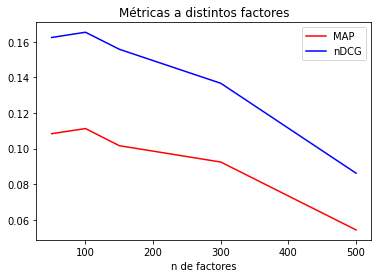

In [96]:
facts = [50, 100,150,300,500]
maps_facts = []
ndcgs_facts = []
for f in facts:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  maps_facts.append(maprec)
  ndcgs_facts.append(ndcg)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))

plt.plot(facts, maps_facts, "r-")
plt.plot(facts, ndcgs_facts, "b-")
plt.legend(["MAP", "nDCG"])
plt.xlabel("n de factores")
plt.title("Métricas a distintos factores")
plt.show()

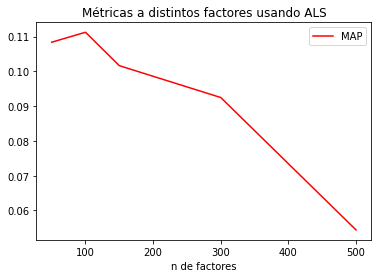

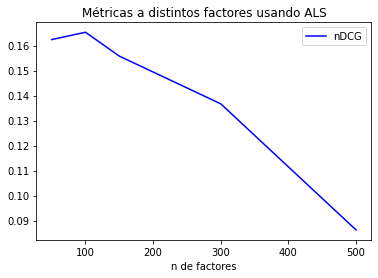

In [97]:
plt.plot(facts, maps_facts, "r-")
plt.xlabel("n de factores")
plt.title("Métricas a distintos factores usando ALS")
plt.legend(["MAP"])
plt.show()

plt.plot(facts, ndcgs_facts, "b-")
plt.xlabel("n de factores")
plt.legend(["nDCG"])
plt.title("Métricas a distintos factores usando ALS")
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

map: 0.11349717826555504
ndcg: 0.17231583049696983


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.11300043754101953
ndcg: 0.16531175056425565


  0%|          | 0/15 [00:00<?, ?it/s]

map: 0.11039178152118442
ndcg: 0.1666123697523164


  0%|          | 0/30 [00:00<?, ?it/s]

map: 0.11242981112812674
ndcg: 0.16701265822170075


  0%|          | 0/50 [00:00<?, ?it/s]

map: 0.11467960248588135
ndcg: 0.1701122224214121


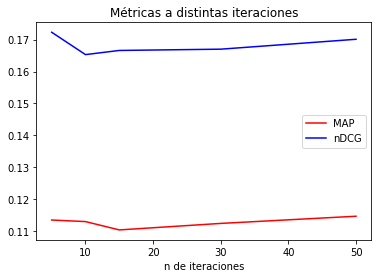

In [98]:
its = [5, 10,15,30,50]
maps_its = []
ndcgs_its = []
for i in its:
  # Definimos y entrenamos el modelo con optimización ALS
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=i, use_gpu=False)
  model_als.fit(matrix)
  maprec, ndcg = evaluate_model(model_als, n=10)
  maps_its.append(maprec)
  ndcgs_its.append(ndcg)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))

plt.plot(its, maps_its, "r-")
plt.plot(its, ndcgs_its, "b-")
plt.legend(["MAP", "nDCG"])
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones")
plt.show()

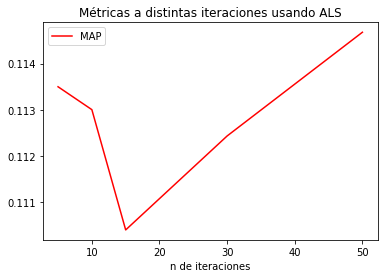

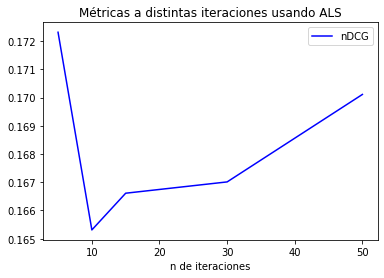

In [99]:
plt.plot(its, maps_its, "r-")
plt.xlabel("n de factores")
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones usando ALS")
plt.legend(["MAP"])
plt.show()

plt.plot(its, ndcgs_its, "b-")
plt.xlabel("n de factores")
plt.legend(["nDCG"])
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones usando ALS")
plt.show()

No hay una diferencia considerable al mover las iteraciones pero sí al considerar más factores, donde se va perdiendo precision media. 

## BPR

**Pregunta 3:** Explique con sus palabras la intuición del framework BPR.

**Respuesta**: Se busca un ordenamiento respaldado con la mayor probabilidad (teorema de Bayes), más que calcular un score y luego ordenar, lo que sería muy caro.

In [100]:
# Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=40, use_gpu=False)
model_bpr.fit(matrix)

  0%|          | 0/40 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [101]:
show_recommendations(model_bpr, user=77, n=10)

movieid
257              Men in Black (1997)
285            Secrets & Lies (1996)
327                  Cop Land (1997)
332            Kiss the Girls (1997)
244    Smilla's Sense of Snow (1997)
299                   Hoodlum (1997)
746               Real Genius (1985)
331                 Edge, The (1997)
267                          unknown
275     Sense and Sensibility (1995)
Name: title, dtype: object

In [102]:
show_similar_movies(model_bpr, item=171, n=10)

movieid
171              Delicatessen (1991)
209        This Is Spinal Tap (1984)
27                   Bad Boys (1995)
203                Unforgiven (1992)
68                  Crow, The (1994)
78                 Free Willy (1993)
201              Evil Dead II (1987)
233               Under Siege (1992)
21     Muppet Treasure Island (1996)
194                Sting, The (1973)
Name: title, dtype: object

In [103]:
maprec, ndcg = evaluate_model(model_bpr, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.12135149533694718
ndcg: 0.18067479308010007


**Pregunta 4:** Pruebe distintos valores para los parámetros de BPR y muestre gráficos de cómo se ven afectadas las métricas de ranking (nDCG@10 y MAP) recién mostradas.

  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.11162896926679478
ndcg: 0.16657345212004201


  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.11310380660686951
ndcg: 0.16828030254638424


  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.10979494316018061
ndcg: 0.16940515261166164


  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.11582657778101896
ndcg: 0.17865799050018977


  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.10837050406345981
ndcg: 0.16651681584482964


  0%|          | 0/40 [00:00<?, ?it/s]

map: 0.11796678131861905
ndcg: 0.17900634018672798


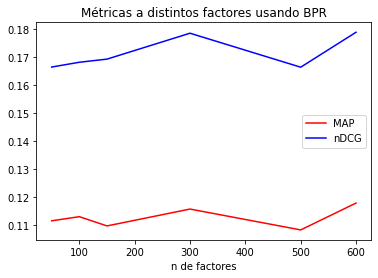

In [104]:
facts = [50, 100,150,300,500,600]
maps_facts = []
ndcgs_facts = []
for f in facts:
  # Definimos y entrenamos el modelo de implicit feedback utilizando optimizacion BPR
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=40, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  maps_facts.append(maprec)
  ndcgs_facts.append(ndcg)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))

plt.plot(facts, maps_facts, "r-")
plt.plot(facts, ndcgs_facts, "b-")
plt.legend(["MAP", "nDCG"])
plt.xlabel("n de factores")
plt.title("Métricas a distintos factores usando BPR")
plt.show()

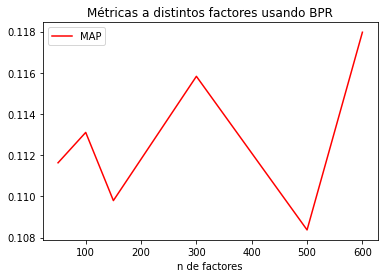

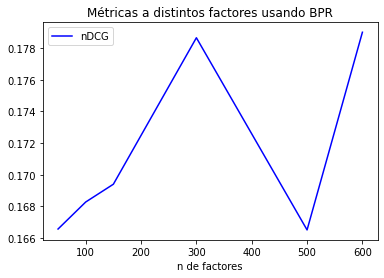

In [105]:
plt.plot(facts, maps_facts, "r-")
plt.xlabel("n de factores")
plt.title("Métricas a distintos factores usando BPR")
plt.legend(["MAP"])
plt.show()

plt.plot(facts, ndcgs_facts, "b-")
plt.xlabel("n de factores")
plt.legend(["nDCG"])
plt.title("Métricas a distintos factores usando BPR")
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

map: 0.09236425087305652
ndcg: 0.14899233143670934


  0%|          | 0/10 [00:00<?, ?it/s]

map: 0.09188109215100036
ndcg: 0.14751055037266342


  0%|          | 0/15 [00:00<?, ?it/s]

map: 0.11600397433092699
ndcg: 0.1742167304592939


  0%|          | 0/30 [00:00<?, ?it/s]

map: 0.10909214289765605
ndcg: 0.1695323735823573


  0%|          | 0/50 [00:00<?, ?it/s]

map: 0.09548512360533809
ndcg: 0.14579233767381836


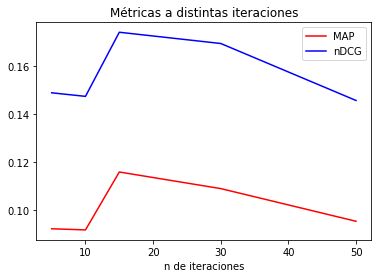

In [106]:
its = [5, 10,15,30,50]
maps_its = []
ndcgs_its = []
for i in its:
  # Definimos y entrenamos el modelo con optimización ALS
  model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=400, iterations=i, use_gpu=False)
  model_bpr.fit(matrix)
  maprec, ndcg = evaluate_model(model_bpr, n=10)
  maps_its.append(maprec)
  ndcgs_its.append(ndcg)
  print('map: {}\nndcg: {}'.format(maprec, ndcg))

plt.plot(its, maps_its, "r-")
plt.plot(its, ndcgs_its, "b-")
plt.legend(["MAP", "nDCG"])
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones")
plt.show()

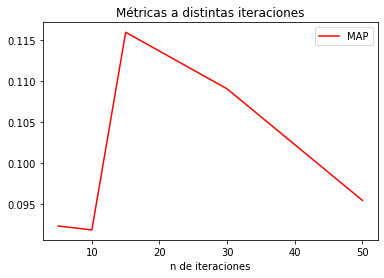

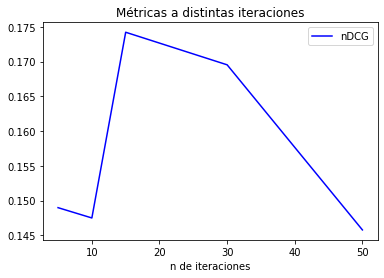

In [107]:
plt.plot(its, maps_its, "r-")
plt.xlabel("n de factores")
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones")
plt.legend(["MAP"])
plt.show()

plt.plot(its, ndcgs_its, "b-")
plt.xlabel("n de factores")
plt.legend(["nDCG"])
plt.xlabel("n de iteraciones")
plt.title("Métricas a distintas iteraciones")
plt.show()

En este caso se nota un aumento en las métricas (aunque un poco leve) al mover los factores, pero una decaida (casi imperceptible) al aumentar el número de iteraciones.